In [33]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic langchain_community

In [34]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

In [35]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [37]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=5)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [38]:
graph = graph_builder.compile(checkpointer=memory)

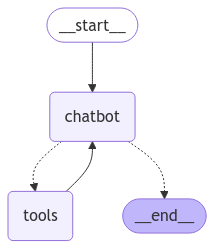

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
config = {"configurable": {"thread_id": "1"}}

In [46]:
user_input = "When is he going to take oath?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

When is he going to take oath?
================================== Ai Message ==================================

[{'text': "To answer your question about when Donald Trump will take the oath of office, I'll need to look up the specific information about the inauguration date. Let me search for that information.", 'type': 'text'}, {'id': 'toolu_01Sc7nzFcCUqQjftdft1Jwj9', 'input': {'query': 'Donald Trump 2024 election win inauguration date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Sc7nzFcCUqQjftdft1Jwj9)
 Call ID: toolu_01Sc7nzFcCUqQjftdft1Jwj9
  Args:
    query: Donald Trump 2024 election win inauguration date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.usatoday.com/story/news/politics/elections/2024/11/07/donald-trump-inauguration-dates/76109453

In [47]:
%pip install gradio

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.115.6-py3-none-any.whl.metadata (27 kB)
  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached typer-0.15.1-py3-none-any.whl.metadata (15 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached starlette-0.41.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 48.2 MB/s eta 0:00:0000:0100:01
Using cached aiofiles-23.2.1-py3-none-any.whl (15

In [48]:
import gradio as gr

def process_message(user_input, history):
    config = {"configurable": {"thread_id": "1"}}
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    full_response = ""
    for event in events:
        if "messages" in event:
            full_response = event["messages"][-1].content
    return full_response

iface = gr.ChatInterface(fn=process_message)
iface.launch()

/Users/vinothrajalingam/miniconda3/envs/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/vinothrajalingam/miniconda3/envs/venv/lib/python3.13/site-packages/gradio/components/chatbot.py:279: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [49]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [51]:
import streamlit as st

st.title("AI Chat")

# Initialize chat history in session state if it doesn't exist
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages from history
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

def process_message(user_input):
    config = {"configurable": {"thread_id": "2"}}
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    full_response = ""
    for event in events:
        if "messages" in event:
            full_response = event["messages"][-1].content
    return full_response

# User input
if prompt := st.chat_input("What is up?"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    # Display user message
    with st.chat_message("user"):
        st.markdown(prompt)

    # Process message and get response
    response = process_message(prompt)

    # Add assistant message to chat history
    st.session_state.messages.append({"role": "assistant", "content": response})
    # Display assistant message
    with st.chat_message("assistant"):
        st.markdown(response)

2025-01-20 12:01:17.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.343 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 12:01:17.343 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar